# Part 6: Data-driven model of battery with SINDy

SINDy stands for Sparse identification of nonlinear dynamics. Unlike DMDc-type methods, where we sought a linear system approximation to the dynamics, with SINDy we seek a non linear system. In this tutorial, we see how to create a simple SINDy system in Collimator.

## Dataset
We utilise the same dataset as in the previous tutorial. We also resample the dataset at a frequency of 10Hz.

## SINDy

Through SINDy, we will seek a battery model of the following form:

\begin{align}
v_t[k+1] &= f(v_t[k],  d[k], i[k]) \\[10pt]
d[k+1] &= g(v_t[k],  d[k], i[k]),
\end{align}

where $f$ and $g$ are nonlinear functions, whose form will be deduced by the SINDy algorithm from a family of functions.

Note: With SINDy one may also seek a continuous-time model for the dynamics. However, continuing the the thread of discrete-time models that we created with DMDc, we only demonstrate discrete-time SINDy model here.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

from math import ceil

from jax import config

config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

import pandas as pd
from scipy.io import loadmat

train_file_name = "dataset_25deg/10-28-18_17.44 551_UDDS_25degC_LGHG2.mat"
val_file_name = "dataset_25deg/10-29-18_14.41 551_Mixed1_25degC_LGHG2.mat"

tain_data = loadmat(train_file_name)
val_data = loadmat(val_file_name)

Q = 3.0  # battery capacity is known to be 3Ah (LG HG2 cell)


def extract_features_from_matfile(filename, Q=3.0, dt=0.1):
    data = loadmat(filename)
    t = data["meas"][0][0][0]
    vt = data["meas"][0][0][2]
    curr = -data["meas"][0][0][3]
    D = -data["meas"][0][0][4]

    # Resample
    T_end = t[-1, 0]
    t_resampled = np.linspace(0.0, T_end, ceil(T_end / dt))
    vt_resampled = np.interp(t_resampled, t[:, 0], vt[:, 0])
    curr_resampled = np.interp(t_resampled, t[:, 0], curr[:, 0])
    D_resampled = np.interp(t_resampled, t[:, 0], D[:, 0])

    return (t_resampled, vt_resampled, curr_resampled, D_resampled)


t_train, vt_train, curr_train, d_train = extract_features_from_matfile(train_file_name)
t_val, vt_val, curr_val, d_val = extract_features_from_matfile(val_file_name)

Collimator has native support for SINDy with the `collimator.library.Sindy` block. The input data for this block is in the form of a `csv` file. Thus, we create two separate files for training and validation as follows:

In [2]:
datadict_train = {
    "t_train": t_train,
    "vt_train": vt_train,
    "curr_train": curr_train,
    "d_train": d_train,
}

datadict_val = {
    "t_val": t_val,
    "vt_val": vt_val,
    "curr_val": curr_val,
    "d_val": d_val,
    
}

df_train = pd.DataFrame(datadict_train)
file_name_train = "batery_sindy_train.csv"
df_train.to_csv(file_name_train)

df_val = pd.DataFrame(datadict_val)
file_name_val = "batery_sindy_val.csv"
df_val.to_csv(file_name_val)

dt = 0.1 # data is sampled at 10 Hz

In [3]:
import collimator
from collimator.framework import LeafSystem, parameters
from collimator.library import Sindy
from collimator.simulation import SimulatorOptions, ODESolverOptions

from typing import NamedTuple

### Training a SINDy model

We can create a Collimator SINDy block easily by passing all the required information to the `collimator.library.Sindy` initializer.

In [4]:
# Create the SINDy model
sindy = Sindy(
    file_name=file_name_train, # file containing data for training
    header_as_first_row=True,  # above file has a header as first row
    state_columns=["vt_train", "d_train"], # columns for state (v_t, d)
    control_input_columns="curr_train",    # control input (i)
    discrete_time=True,
    threshold=1e-05, # threshold for STLSQ algorithm
    alpha=0.1,       # regularization strength for STLSQ algorithm
    max_iter=500,    # max iterations for STSLQ algorithm
    normalize_columns=True, # normalize columns before regression
    poly_order=2,    # degree of polynomial features
    initial_state=jnp.array([vt_train[0], d_train[0]]), # initial state for simulation
    discrete_time_update_interval = dt, # discrete-time interval
    name="sindy",
)

/Volumes/LaCie/collimator/src/lib/wildcat/collimator/library/sindy.py:212: UserWarning: Neither fixed dt nor column for time data are provided. Default dt=1.0 will be used for SINDy training
  warnings.warn(
collimator:WARNING SINDy block does not support re-initialization yet.


The above call creates and trains the SINDy block. We can check the found equations by `sindy.equations`:

In [5]:
sindy.equations

['-0.479 1 + 1.258 x0[k] + 0.055 x1[k] + 0.005 u0[k] + -0.034 x0[k]^2 + -0.015 x0[k] x1[k] + -0.001 x0[k] u0[k] + -0.002 x1[k]^2',
 '0.001 1 + 1.000 x1[k]']

The state `n` variables are labelled `x0`, `x1`, ..., `xn`, and the `m` control variables are labelled `u0`, `u1`, ..., `um`. `sindy.equations` is a list of equations for each state variable.

### Simulate trained SINDy model for the training data

To simulate the SINDy block with training inputs for evaluation, we need the `DiscreteSource` block as in previous tutorials. A minor change here is that we make the `val_array` as a dynamic parameter so that we can change its value in the context.

In [6]:
class DiscreteSource(LeafSystem):
    class DiscreteStateType(NamedTuple):
        index: jnp.int64
        source_val: jnp.float64

    @parameters(dynamic=["val_array"])
    def __init__(self, val_array, dt, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.dt = dt

        self.declare_discrete_state(
            default_value=self.DiscreteStateType(index=0, source_val=val_array[0]),
            as_array=False,
        )

        self.declare_periodic_update(
            self._update,
            period=self.dt,
            offset=0,
        )

        self.declare_output_port(
            self._compute_output,
            default_value=val_array[0],
            period=self.dt,
            offset=0.0,
            requires_inputs = False,
        )

    def _compute_output(self, time, state, **params):
        return state.discrete_state.source_val

    def _update(self, time, state, *inputs, **params):
        index = state.discrete_state.index
        index = index + 1
        source_val = params["val_array"][index]
        return self.DiscreteStateType(index=index, source_val=source_val)

We can now create a diagram with the training control input, connect it to the SINDy block, and see how its predictions compare with the experimental data.

collimator:WARNING SINDy block does not support re-initialization yet.
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=159656, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


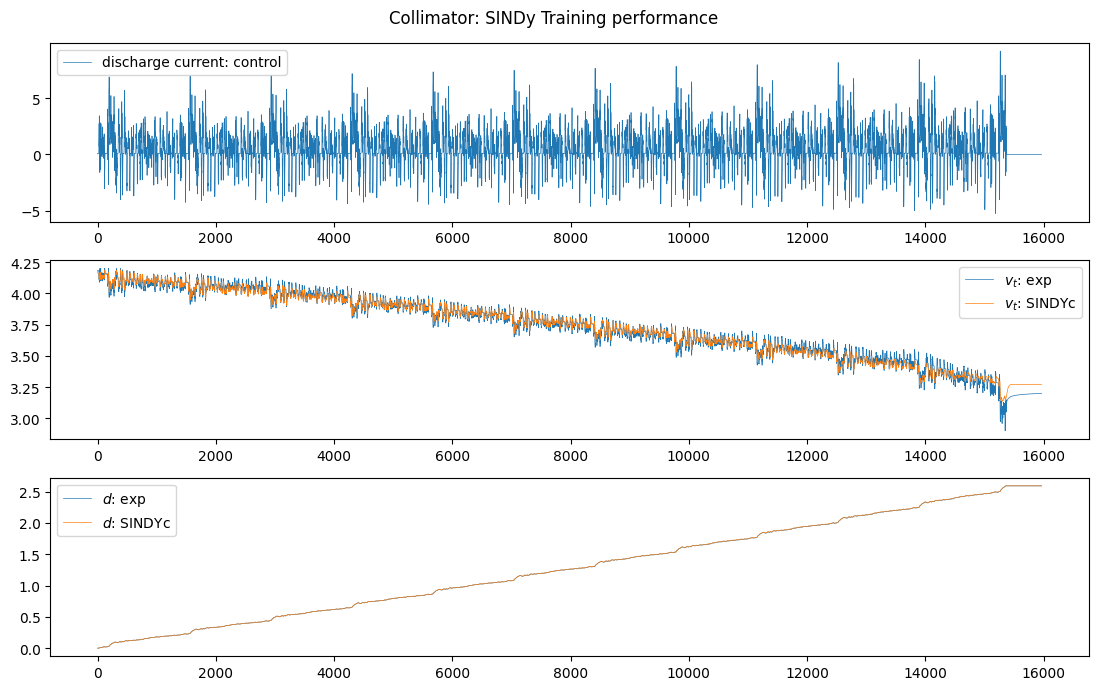

In [7]:
builder = collimator.DiagramBuilder()

builder.add(sindy)

# create the current input (train) for the SINDy block
control = builder.add(DiscreteSource(jnp.array(curr_train), dt=dt, name="control"))

builder.connect(control.output_ports[0], sindy.input_ports[0])

diagram = builder.build()
context = diagram.create_context()

recorded_signals = {
    "state": diagram["sindy"].output_ports[0],
    "control": diagram["control"].output_ports[0],
}

options = SimulatorOptions(max_major_steps=ceil(t_train[-1] / dt))
sol = collimator.simulate(
    diagram,
    context,
    (0.0, t_train[-1]),
    options=options,
    recorded_signals=recorded_signals,
)

state_names = ["$v_t$", "$d$"]
state_data = np.vstack([vt_train, d_train]).T  # exp data for plotting

lw=0.5
fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(sol.time, sol.outputs["control"], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_train, state_data[:, i], label=state_names[i] + ": exp", lw=lw)
    ax.plot(
        sol.time, sol.outputs["state"][:, i], label=state_names[i] + ": SINDYc", lw=lw
    )
    ax.legend(loc="best")
fig.suptitle("Collimator: SINDy Training performance")
plt.tight_layout()
plt.show()

As before, we can compute the errors:

In [8]:
def compute_prediction_error(pred_state, state_data):
    rms_err = []
    for y, x in zip(pred_state.T, state_data.T):
        rms_err.append(np.sqrt(np.average((y - x) ** 2)))
    return rms_err

print("RMS: error:", compute_prediction_error(sol.outputs["state"][:-1], state_data))

RMS: error: [0.030799468469697708, 0.0016714548087336022]


## Augmenting SINDyc model
The above model is reasonably good. However, increasing the degree of polynomials in the feature library does not lead to any further improvement. We can augment the system with some of our own basis functions and see if we get any improvements. Similarly to `part_4` of this series, we can use $1/x^2$ and $\exp \left(-\frac{1}{2 x^2}\right)$ as our custom basis functions.

In [9]:
eps = 1e-06 # to avoid divide by zero.
custom_basis_functions = [
    lambda x: jnp.exp(-0.5 / (x + eps) ** 2),
    lambda x: 1.0 / (x + eps),
]

Adding custom basis functions is quite easy in Collimator. We can pass the above list of custom basis functions to the SINDy block initializer.

collimator:WARNING SINDy block does not support re-initialization yet.
collimator:WARNING SINDy block does not support re-initialization yet.
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=159656, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


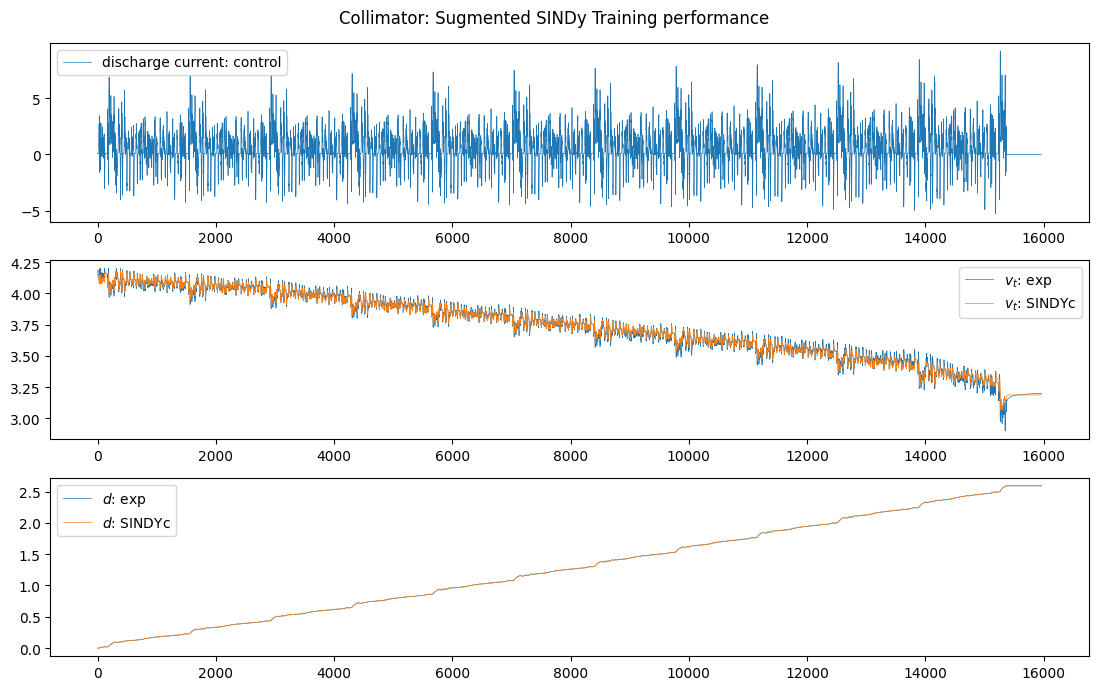

RMS: error: [0.0203881106186403, 0.0010329057668171627]


In [10]:
builder = collimator.DiagramBuilder()

# Create the SINDy model
sindy = Sindy(
    file_name=file_name_train,
    header_as_first_row=True,
    state_columns=["vt_train", "d_train"],
    control_input_columns="curr_train",
    discrete_time=True,
    threshold=1e-05,
    alpha=0.1,
    max_iter=500,
    normalize_columns=True,
    poly_order=2,
    custom_basis_functions=custom_basis_functions,
    initial_state=jnp.array([vt_train[0], d_train[0]]),
    discrete_time_update_interval = dt,
    name="sindy",
)
builder.add(sindy)

# create the current input (train) for the SINDy block
control = builder.add(DiscreteSource(jnp.array(curr_train), dt=dt, name="control"))

builder.connect(control.output_ports[0], sindy.input_ports[0])

diagram = builder.build()
context = diagram.create_context()

recorded_signals = {
    "state": diagram["sindy"].output_ports[0],
    "control": diagram["control"].output_ports[0],
}

options = SimulatorOptions(max_major_steps=ceil(t_train[-1] / dt))
sol = collimator.simulate(
    diagram,
    context,
    (0.0, t_train[-1]),
    options=options,
    recorded_signals=recorded_signals,
)

state_names = ["$v_t$", "$d$"]
state_data = np.vstack([vt_train, d_train]).T  # exp data for plotting

lw=0.5
fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(sol.time, sol.outputs["control"], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_train, state_data[:, i], label=state_names[i] + ": exp", lw=lw)
    ax.plot(
        sol.time, sol.outputs["state"][:, i], label=state_names[i] + ": SINDYc", lw=lw
    )
    ax.legend(loc="best")
fig.suptitle("Collimator: Sugmented SINDy Training performance")
plt.tight_layout()
plt.show()

print("RMS: error:", compute_prediction_error(sol.outputs["state"][:-1], state_data))

### Validation

We can run the model on unseen data to validate its predictive power. We don't have to create a new diagram; instead, we can modify the values reflecting the validation setting in the context. There are two variables we need to modify: (i) the `initial_state` for the SINDy block; and (ii) the `val_array` for the control input block.

In [11]:
sindy_updated_subcontext = context[sindy.system_id].with_parameter("initial_state", jnp.array([vt_val[0], d_val[0]]))
control_updated_subcontext = context[control.system_id].with_parameter("val_array", jnp.array(curr_val))

validation_context = context.with_subcontext(sindy.system_id, sindy_updated_subcontext)
validation_context = validation_context.with_subcontext(control.system_id, control_updated_subcontext)

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=159656, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


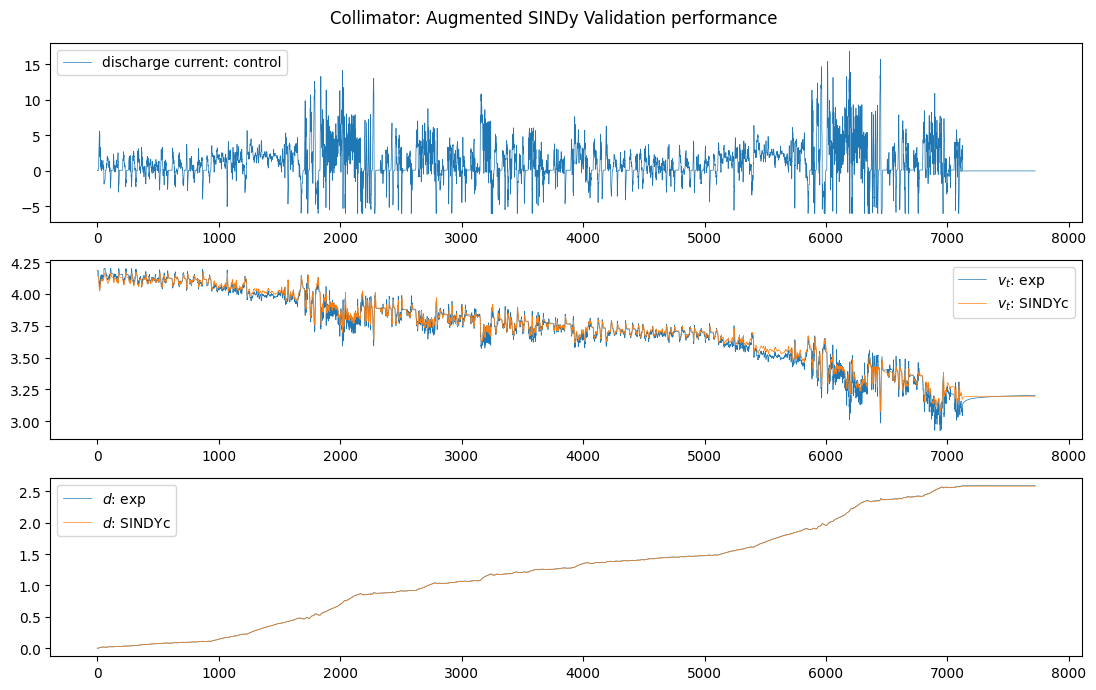

RMS: error: [0.03576966438528527, 0.002762163313330932]


In [12]:
sol = collimator.simulate(
    diagram,
    validation_context,
    (0.0, t_val[-1]),
    options=options,
    recorded_signals=recorded_signals,
)

state_names = ["$v_t$", "$d$"]
state_data = np.vstack([vt_val, d_val]).T  # exp data for plotting

lw=0.5
fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(sol.time, sol.outputs["control"], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_val, state_data[:, i], label=state_names[i] + ": exp", lw=lw)
    ax.plot(
        sol.time, sol.outputs["state"][:, i], label=state_names[i] + ": SINDYc", lw=lw
    )
    ax.legend(loc="best")
fig.suptitle("Collimator: Augmented SINDy Validation performance")
plt.tight_layout()
plt.show()

print("RMS: error:", compute_prediction_error(sol.outputs["state"][:-1], state_data))